In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
model_learning_rate = 1e-2
warmup_learning_rate = 20
learning_rate = 1

In [7]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [8]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [9]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]
warmup_mild = warmup_mild[Vax.no.value] + warmup_asymp[Vax.yes_value]

In [10]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [11]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    

In [12]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)

2021-12-13 11:14:54.382786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-13 11:14:54.382985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 11:14:54.383034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-13 11:14:54.383071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-13 11:14:54.383105: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [13]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [14]:

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}




In [15]:
T_serial_scale = 1.0
rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

warmup_scales = [0.1]*warmup_asymp

In [54]:
T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(4.0),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}

rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                      'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(5.0),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

for day in range(transition_window):
    # must be positive so reverse softplus the mean
    warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(2000.0),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(500.0),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

model = CovidModel([Vax.total], [Comp.A, Comp.M],
                 transition_window,
                T_serial, rho_M, lambda_M, nu_M,
                 warmup_A_params, posterior_samples=1000, debug_disable_theta=False)

pre_training_preds=tf.reduce_mean(model.call(x_train), axis=-1)

In [55]:
model.variables

[<tf.Variable 'T_serial_A_loc_-1:0' shape=() dtype=float32, numpy=3.9815147>,
 <tf.Variable 'T_serial_A_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'rho_M_loc_-1:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'rho_M_scale_-1:0' shape=() dtype=float32, numpy=-2.2521684>,
 <tf.Variable 'lambda_M_loc_-1:0' shape=() dtype=float32, numpy=2.9489307>,
 <tf.Variable 'lambda_M_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'nu_M_loc_-1:0' shape=() dtype=float32, numpy=4.9932394>,
 <tf.Variable 'nu_M_scale_-1:0' shape=() dtype=float32, numpy=0.8416177>,
 <tf.Variable 'warmup_A_loc_0_-1:0' shape=() dtype=float32, numpy=2000.0>,
 <tf.Variable 'warmup_A_scale_0_-1:0' shape=() dtype=float32, numpy=500.0>,
 <tf.Variable 'warmup_A_loc_1_-1:0' shape=() dtype=float32, numpy=2000.0>,
 <tf.Variable 'warmup_A_scale_1_-1:0' shape=() dtype=float32, numpy=500.0>,
 <tf.Variable 'warmup_A_loc_2_-1:0' shape=() dtype=float32, numpy=2000.0>,
 <tf.Variable 'warmu

In [56]:
model_variables = model.variables[:-6]
assert all(['warmup' not in variable.name for variable in model_variables])
warmup_variables = model.variables[-6:]
assert all(['warmup' in variable.name for variable in warmup_variables])

In [57]:
loss = LogPoisstf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.onProb() 

model_opt = tf.keras.optimizers.Adam(
    learning_rate=model_learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)
warmup_opt = tf.keras.optimizers.Adam(
    learning_rate=warmup_learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)
grads = tf.gradients(loss, model_variables + warmup_variables )
model_grads = grads[:len(model_variables)]
warmup_grads = grads[len(warmup_variables):]
model_train_op = opt1.apply_gradients(zip(model_grads, model_variables))
warmup_train_op = opt2.apply_gradients(zip(warmup_grads, warmup_variables))
train_op = tf.group(model_train_op, warmup_train_op)

SyntaxError: invalid syntax (341888841.py, line 1)

In [58]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1, #beta_1=0.1, beta_2=0.1
)

In [59]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01')

2021-12-13 12:07:14.968371: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-13 12:07:14.968402: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-13 12:07:14.968478: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-13 12:07:14.968663: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-13 12:07:14.968753: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [65]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([y_test]),
         epochs=500, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 993.2242
Epoch 2/500


2021-12-13 12:47:55.277041: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-13 12:47:55.277072: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-13 12:47:55.277310: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 995.5760

2021-12-13 12:47:57.814693: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-13 12:47:57.820860: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-13 12:47:57.995376: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-13 12:47:58.314903: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-13 12:47:59.212863: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/profile/2021_12_13_12_47_58

2021-12-13 12:47:59.984573: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/

1/1 [==============================] - 5s 5s/step - loss: 995.5760


2021-12-13 12:48:00.254353: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/profile/2021_12_13_12_47_58

2021-12-13 12:48:00.257169: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/profile/2021_12_13_12_47_58/MrChipsNVME.memory_profile.json.gz
2021-12-13 12:48:00.280087: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/profile/2021_12_13_12_47_58
Dumped tool data for xplane.pb to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/profile/2021_12_13_12_47_58/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_01/train/plugins/profile/2021_12_13_12_47_58/MrChipsNVME.overview_pa

Epoch 3/500
1/1 [==============================] - 2s 2s/step - loss: 986.5211
Epoch 4/500
1/1 [==============================] - 2s 2s/step - loss: 993.4314
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 988.4611
Epoch 6/500
1/1 [==============================] - 2s 2s/step - loss: 989.4211
Epoch 7/500
1/1 [==============================] - 2s 2s/step - loss: 988.0787
Epoch 8/500
1/1 [==============================] - 2s 2s/step - loss: 988.7338
Epoch 9/500
1/1 [==============================] - 2s 2s/step - loss: 991.0002
Epoch 10/500
1/1 [==============================] - 2s 2s/step - loss: 987.5217
Epoch 11/500
1/1 [==============================] - 2s 2s/step - loss: 988.1565
Epoch 12/500
1/1 [==============================] - 2s 2s/step - loss: 993.0857
Epoch 13/500
1/1 [==============================] - 2s 2s/step - loss: 991.3207
Epoch 14/500
1/1 [==============================] - 2s 2s/step - loss: 990.3307
Epoch 15/500
1/1 [=============================

1/1 [==============================] - 2s 2s/step - loss: 978.3990
Epoch 106/500
1/1 [==============================] - 2s 2s/step - loss: 981.1679
Epoch 107/500
1/1 [==============================] - 2s 2s/step - loss: 992.5760
Epoch 108/500
1/1 [==============================] - 2s 2s/step - loss: 996.3748
Epoch 109/500
1/1 [==============================] - 2s 2s/step - loss: 985.4033
Epoch 110/500
1/1 [==============================] - 2s 2s/step - loss: 978.3453
Epoch 111/500
1/1 [==============================] - 2s 2s/step - loss: 981.6016
Epoch 112/500
1/1 [==============================] - 2s 2s/step - loss: 985.8527
Epoch 113/500
1/1 [==============================] - 2s 2s/step - loss: 990.5688
Epoch 114/500
1/1 [==============================] - 2s 2s/step - loss: 991.8648
Epoch 115/500
1/1 [==============================] - 2s 2s/step - loss: 984.6724
Epoch 116/500
1/1 [==============================] - 2s 2s/step - loss: 978.0399
Epoch 117/500
1/1 [=======================

1/1 [==============================] - 2s 2s/step - loss: 983.8566
Epoch 207/500
1/1 [==============================] - 2s 2s/step - loss: 980.2430
Epoch 208/500
1/1 [==============================] - 2s 2s/step - loss: 980.1023
Epoch 209/500
1/1 [==============================] - 2s 2s/step - loss: 987.1780
Epoch 210/500
1/1 [==============================] - 2s 2s/step - loss: 987.7603
Epoch 211/500
1/1 [==============================] - 2s 2s/step - loss: 983.5117
Epoch 212/500
1/1 [==============================] - 2s 2s/step - loss: 981.6703
Epoch 213/500
1/1 [==============================] - 2s 2s/step - loss: 983.3889
Epoch 214/500
1/1 [==============================] - 2s 2s/step - loss: 978.6689
Epoch 215/500
1/1 [==============================] - 2s 2s/step - loss: 984.3407
Epoch 216/500
1/1 [==============================] - 2s 2s/step - loss: 988.9875
Epoch 217/500


KeyboardInterrupt: 

Text(0.5, 1.0, 'Mild Compartment')

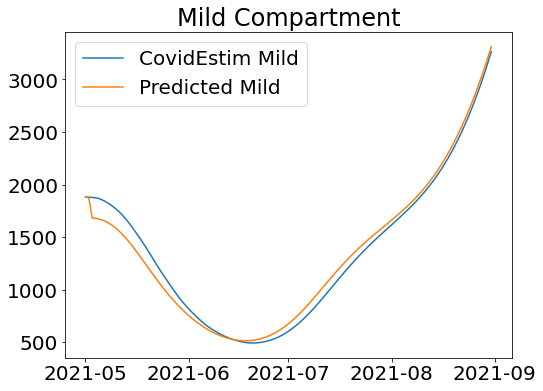

In [66]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

Text(0.5, 1.0, 'Mild Compartment')

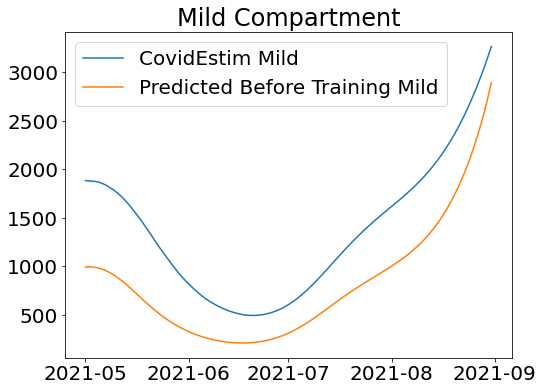

In [62]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, pre_training_preds, label='Predicted Before Training Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [23]:
import tfa.optimizers

ModuleNotFoundError: No module named 'tfa'

In [23]:
0.8*2000

1600.0

In [25]:
warmup_asymp

array([2518.60923786, 2520.22371777, 2518.626799  ])

In [26]:
warmup_mild

{1: array([662.54941002, 674.02507617, 685.83712267]),
 0: array([1225.59367925, 1212.94322218, 1199.88496331])}

In [28]:
y_test

<tf.Tensor: shape=(123,), dtype=float32, numpy=
array([1883.1843 , 1879.9614 , 1878.4843 , 1874.889  , 1867.625  ,
       1855.1506 , 1839.0627 , 1819.4205 , 1797.5369 , 1772.8456 ,
       1745.3354 , 1713.0474 , 1676.8483 , 1637.9723 , 1595.6298 ,
       1550.9956 , 1505.9484 , 1460.1703 , 1411.5771 , 1360.6824 ,
       1309.5687 , 1257.2211 , 1206.9117 , 1158.9786 , 1112.176  ,
       1065.396  , 1019.1018 ,  974.7162 ,  931.76184,  891.36066,
        854.1387 ,  819.2815 ,  786.52826,  754.50806,  724.3344 ,
        696.807  ,  669.4488 ,  646.7868 ,  625.5422 ,  605.7364 ,
        587.4074 ,  570.8427 ,  555.80206,  542.41534,  530.70746,
        520.6189 ,  512.4302 ,  504.1964 ,  498.84677,  495.26813,
        493.92334,  494.2876 ,  496.60837,  500.79382,  506.81006,
        514.7886 ,  524.72736,  536.65625,  550.4345 ,  566.6077 ,
        584.84607,  605.1895 ,  627.5542 ,  651.947  ,  678.33746,
        706.6682 ,  736.8512 ,  768.7289 ,  801.9794 ,  836.5681 ,
        872.29

In [31]:
df.loc[warmup_start:'20210510','mild']

date
2021-04-28    1888.143089
2021-04-29    1886.968298
2021-04-30    1885.722086
2021-05-01    1883.184382
2021-05-02    1879.961460
2021-05-03    1878.484236
2021-05-04    1874.889063
2021-05-05    1867.625053
2021-05-06    1855.150682
2021-05-07    1839.062791
2021-05-08    1819.420564
2021-05-09    1797.536856
2021-05-10    1772.845594
Name: mild, dtype: float64

In [30]:
warmup_start

'20210428'

In [32]:
warmup_asymp

array([2518.60923786, 2520.22371777, 2518.626799  ])

In [67]:
import copy

In [100]:
copy_model = copy.deepcopy(model)
copy_model.unconstrained_warmup_A_params[-1][2]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][1]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][0]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_nu_M[-1]['loc'] = tf.Variable(3.0, dtype=tf.float32)

Text(0.5, 1.0, 'Mild Compartment')

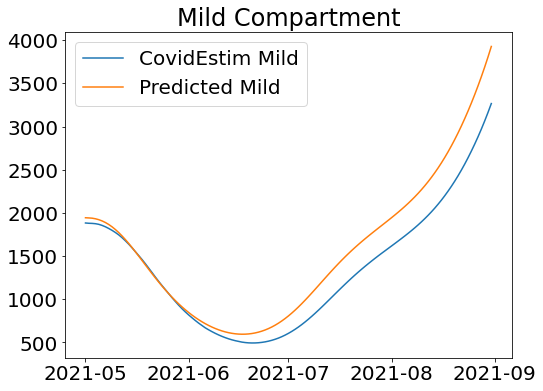

In [129]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, copy_preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [84]:
loss(y_test, copy_model.call(x_train))

<tf.Tensor: shape=(), dtype=float32, numpy=3321.719>

In [81]:
copy_model.unconstrained_nu_M

{-1: {'loc': <tf.Variable 'nu_M_loc_-1:0' shape=() dtype=float32, numpy=-3.4172542>,
  'scale': <tf.Variable 'nu_M_scale_-1:0' shape=() dtype=float32, numpy=-0.5642081>}}

In [85]:
copy_model.unconstrained_rho_M[-1]['loc']

<tf.Variable 'rho_M_loc_-1:0' shape=() dtype=float32, numpy=1.250453>

In [87]:
tf.math.sigmoid(1.2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.76852477>

In [89]:
warmup_A_params[-1]

{'prior': [{'loc': 2518.60923786445, 'scale': 251.86092378644497},
  {'loc': 2520.22371776634, 'scale': 252.022371776634},
  {'loc': 2518.626798999444, 'scale': 251.8626798999444}],
 'posterior_init': [{'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2000.0>,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=500.0>},
  {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2000.0>,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=500.0>},
  {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2000.0>,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=500.0>},
  {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2000.0>,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=500.0>},
  {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2000.0>,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=500.0>},
  {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2000.0>,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=500.0>},
  {'loc': <tf.Tensor: shape=(), dtype=float3

In [91]:
warmup_asymp

array([2518.60923786, 2520.22371777, 2518.626799  ])

In [92]:
warmup_mild

{1: array([662.54941002, 674.02507617, 685.83712267]),
 0: array([1225.59367925, 1212.94322218, 1199.88496331])}

In [95]:
1800/2500

0.72

Text(0.5, 1.0, 'Empirical Rho_M')

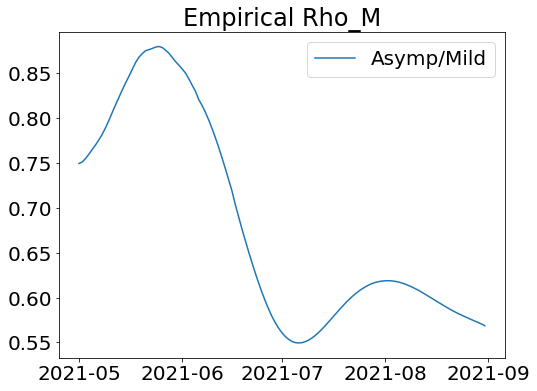

In [115]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, df.loc[train_start:test_end, 'mild']/df.loc[train_start:test_end, 'asymp'], label='Asymp/Mild')
#plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Empirical Rho_M')

In [110]:
0.96**(1/5.2)

0.9881713984184165

In [106]:
warmup_asymp

array([2518.60923786, 2520.22371777, 2518.626799  ])

In [108]:
x_train

<tf.Tensor: shape=(123,), dtype=float32, numpy=
array([0.9893859 , 0.9806603 , 0.9708389 , 0.9601291 , 0.9487467 ,
       0.93690044, 0.9247909 , 0.9126141 , 0.90057087, 0.8888542 ,
       0.87764704, 0.867123  , 0.85742813, 0.84862584, 0.840759  ,
       0.83387077, 0.82800525, 0.8231926 , 0.819385  , 0.8165125 ,
       0.8145094 , 0.8133129 , 0.8128637 , 0.81310666, 0.8139891 ,
       0.8154599 , 0.8174688 , 0.81997126, 0.8229714 , 0.82650083,
       0.83059275, 0.83528215, 0.84060645, 0.8466147 , 0.8533651 ,
       0.8609193 , 0.86934257, 0.8787029 , 0.8890385 , 0.90036035,
       0.9126806 , 0.9260135 , 0.9403739 , 0.95573395, 0.9720139 ,
       0.98912555, 1.0069746 , 1.0254581 , 1.0444374 , 1.0637217 ,
       1.0831019 , 1.1023542 , 1.121239  , 1.1395118 , 1.1569333 ,
       1.173255  , 1.1882203 , 1.2015666 , 1.2130756 , 1.2226428 ,
       1.2301873 , 1.2356372 , 1.2389311 , 1.2400631 , 1.2391775 ,
       1.2364545 , 1.2320814 , 1.2262504 , 1.2191668 , 1.2110765 ,
       1.20223

In [113]:
model.T_serial_samples_constrained

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([5.198659 , 5.2057085, 5.2652006, 5.229498 , 5.2229786, 5.281637 ,
       5.1985784, 5.180516 , 5.2060895, 5.2085915, 5.234597 , 5.2548833,
       5.183585 , 5.250757 , 5.225873 , 5.2383204, 5.2245073, 5.1954923,
       5.1787977, 5.1858673, 5.2298656, 5.239574 , 5.220103 , 5.2331133,
       5.176026 , 5.2012925, 5.1957436, 5.195151 , 5.2332835, 5.206982 ,
       5.2239385, 5.223321 , 5.181737 , 5.230326 , 5.2123575, 5.217191 ,
       5.228753 , 5.260989 , 5.198163 , 5.245516 , 5.2817864, 5.2237515,
       5.1931844, 5.233222 , 5.245469 , 5.234665 , 5.282221 , 5.2336626,
       5.236139 , 5.2617216, 5.214859 , 5.222218 , 5.1954126, 5.198052 ,
       5.1955576, 5.2079387, 5.1909847, 5.2164984, 5.228651 , 5.1958447,
       5.2205486, 5.2373195, 5.2145047, 5.1956353, 5.235926 , 5.2287197,
       5.171189 , 5.206007 , 5.1883717, 5.189143 , 5.2100897, 5.2094307,
       5.240154 , 5.2173862, 5.2556276, 5.226827 , 5.175892 , 5.187935 ,
  

In [116]:
copy_model.call(x_train,return_all=True)

AttributeError: 'dict' object has no attribute 'stack'

In [119]:
warmup_asymp*x_train[2] ** (1/model.T_serial_samples_constrained)

InvalidArgumentError: Incompatible shapes: [3] vs. [1000] [Op:Mul]

In [128]:
copy_model.warmup_A_samples[1]

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([2583.2346, 2419.5955, 2443.0764, 2530.7456, 2561.2058, 2450.3152,
       2550.8037, 2537.0903, 2604.2705, 2467.8909, 2506.2795, 2516.104 ,
       2541.5713, 2547.7625, 2523.8752, 2402.808 , 2513.6643, 2593.0452,
       2534.875 , 2397.1582, 2448.6863, 2485.6892, 2440.5234, 2514.1218,
       2490.6042, 2532.2402, 2399.1265, 2607.0073, 2491.5347, 2521.4346,
       2521.5823, 2527.2085, 2526.0427, 2576.5344, 2635.7156, 2455.9304,
       2588.3152, 2549.9077, 2556.402 , 2538.0234, 2563.326 , 2546.9448,
       2452.5823, 2469.5933, 2549.0593, 2517.475 , 2557.9275, 2496.2898,
       2540.4304, 2524.8816, 2506.4702, 2475.5466, 2478.843 , 2603.097 ,
       2495.009 , 2529.6187, 2480.0244, 2493.7512, 2467.9417, 2443.4731,
       2495.5251, 2445.6165, 2557.6802, 2521.9587, 2481.598 , 2437.613 ,
       2528.5735, 2492.8457, 2523.4763, 2584.4614, 2594.4612, 2467.0083,
       2562.9417, 2529.3357, 2500.2246, 2537.9648, 2482.88  , 2471.9631,
  

In [126]:
warmup_A

NameError: name 'warmup_A' is not defined